# Embedding Data Preparation Transformer Explorer Demo (Script 1)

Prepares pre-trained GloVe embedding data for the HTML/JS demo.

**Produces two JSON files:**
- `embeddings_projected.json` 2D/3D coordinates + category metadata (for scatter plot)
- `embeddings_full.json` full-dimensional vectors (for nearest-neighbor search & analogies in JS)

**Expected runtime:** ~5 min first run (GloVe download), ~1 min (cached) thereafter.


In [1]:
# ============================================================
# 1. DEPENDENCIES
# ============================================================
!pip install gensim umap-learn matplotlib numpy scikit-learn

import importlib
for pkg in ["numpy", "gensim", "matplotlib", "sklearn", "json"]:
    importlib.import_module(pkg)

print("\nAll core dependencies OK.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 11.0 MB/s  0:00:02 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [umap-learn]5 [gensim]

All core dependencies OK.


In [2]:
# ============================================================
# 2. CONFIGURATION
# ============================================================
import numpy as np
import json
from pathlib import Path

# --- Embedding source ---
# "glove-wiki-gigaword-50"  → ~70 MB download, faster, lower quality
# "glove-wiki-gigaword-300" → ~400 MB download, slower, much better analogies
EMBEDDING_SOURCE = "glove-wiki-gigaword-300"

# --- Vocabulary ---
TARGET_VOCAB_SIZE = 3000  # curated words + high-frequency fill

# --- Output ---
OUTPUT_DIR = Path("/home/jovyan/demo_data")
OUTPUT_DIR.mkdir(exist_ok=True)

# --- Precision (decimal places in exported JSON) ---
VECTOR_PRECISION = 4   # full vectors. 4 is plenty for cosine similarity
COORD_PRECISION  = 3   # 2D projection coordinates

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
# ============================================================
# 3. LOAD PRE-TRAINED EMBEDDINGS
# ============================================================
import gensim.downloader as api

print(f"Loading '{EMBEDDING_SOURCE}' ...")
print("(First run downloads to ~/gensim-data/. Subsequent runs use cache.)\n")

model = api.load(EMBEDDING_SOURCE)

print(f"✓ Loaded {len(model):,} word vectors, {model.vector_size} dimensions")
print(f"  Example - model['king'].shape = {model['king'].shape}")

Loading 'glove-wiki-gigaword-300' ...
(First run downloads to ~/gensim-data/. Subsequent runs use cache.)

[===-----------------------------------------------] 6.2% 23.4/376.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=========-----------------------------------------] 18.9% 70.9/376.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===============-----------------------------------] 31.2% 117.2/376.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=====================-----------------------------] 43.5% 163.7/376.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===========================-----------------------] 55.9% 210.4/376.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==================================----------------] 68.5% 257.5/376.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[========================================----------] 80.7% 303.6/376.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==============================================----] 93.0% 349.9/376.1MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 376.1/376.1MB downloaded
✓ Loaded 400,000 word vectors, 300 dimensions
  Example - model['king'].shape = (300,)


In [4]:
# ============================================================
# 4. DEFINE CURATED VOCABULARY
# ============================================================
# Two tiers:
#   DEMO_CATEGORIES: "Explore Clusters" buttons in the JS demo
#   ENRICHMENT: add visual cluster richness to the scatter plot
#
# Words can belong to multiple categories (e.g., "king" is in both "royalty" and "analogy").

DEMO_CATEGORIES = {
    "royalty": {
        "words": [
            "king", "queen", "prince", "princess", "throne", "crown",
            "royal", "kingdom", "monarch", "emperor", "empress", "palace",
            "knight", "duke", "duchess", "noble", "reign", "dynasty",
            "sovereign", "castle", "coronation", "majesty",
        ],
        "color": "#9B59B6",
        "label": "Royalty",
    },
    "food": {
        "words": [
            "pizza", "pasta", "sushi", "bread", "rice", "chicken",
            "cheese", "chocolate", "coffee", "tea", "soup", "cake",
            "fruit", "vegetable", "meat", "butter", "sugar",
            "wine", "beer", "salad", "burger", "steak", "cookie",
            "sandwich", "breakfast", "dinner", "lunch", "dessert",
            "restaurant", "delicious",
        ],
        "color": "#27AE60",
        "label": "Food",
    },
    "programming": {
        "words": [
            "code", "program", "function", "variable", "loop", "array",
            "algorithm", "software", "computer", "debug", "compile",
            "syntax", "database", "server", "python", "javascript",
            "html", "api", "class", "object", "method", "library",
            "programming", "developer", "bug", "script", "binary",
            "data", "network", "internet", "processor", "memory",
        ],
        "color": "#2980B9",
        "label": "Programming",
    },
    "bank_ambiguity": {
        "words": [
            "bank", "river", "water", "shore", "deposit", "loan",
            "credit", "finance", "money", "account", "interest",
            "investment", "savings", "financial", "stream", "creek",
            "steep", "erosion", "flood", "mortgage", "debt",
            "currency", "banking", "valley", "cliff", "riverbank",
        ],
        "color": "#E67E22",
        "label": "Bank (Ambiguity)",
    },
}

ENRICHMENT_CATEGORIES = {
    "analogy": {
        "words": [
            # gender pairs
            "man", "woman", "boy", "girl", "brother", "sister",
            "father", "mother", "son", "daughter", "husband", "wife",
            "uncle", "aunt", "nephew", "niece", "male", "female",
            # capital–country pairs
            "paris", "france", "tokyo", "japan", "berlin", "germany",
            "london", "england", "rome", "italy", "madrid", "spain",
            "beijing", "china", "moscow", "russia", "cairo", "egypt",
            # comparative pairs
            "big", "bigger", "small", "smaller", "fast", "faster",
        ],
        "color": "#E74C3C",
        "label": "Analogy Pairs",
    },
    "animals": {
        "words": [
            "dog", "cat", "horse", "bird", "lion", "tiger", "bear",
            "elephant", "monkey", "snake", "whale", "dolphin", "eagle",
            "wolf", "rabbit", "deer", "mouse", "shark", "penguin",
            "fox", "giraffe", "zebra", "gorilla", "parrot", "turtle",
        ],
        "color": "#1ABC9C",
        "label": "Animals",
    },
    "emotions": {
        "words": [
            "happy", "sad", "angry", "fear", "love", "hate", "joy",
            "grief", "hope", "anxiety", "excitement", "calm", "proud",
            "shame", "surprise", "trust", "jealousy", "lonely",
            "grateful", "nervous", "despair", "delight", "fury",
        ],
        "color": "#E91E63",
        "label": "Emotions",
    },
    "science": {
        "words": [
            "atom", "molecule", "cell", "gene", "protein", "energy",
            "gravity", "electron", "quantum", "evolution", "chemical",
            "physics", "biology", "experiment", "theory", "hypothesis",
            "research", "laboratory", "microscope", "telescope",
            "neutron", "photon", "genome", "organism",
        ],
        "color": "#F39C12",
        "label": "Science",
    },
    "sports": {
        "words": [
            "football", "basketball", "baseball", "soccer", "tennis",
            "golf", "swimming", "running", "boxing", "hockey",
            "volleyball", "cricket", "rugby", "athlete", "championship",
            "stadium", "coach", "team", "score", "tournament",
            "goalkeeper", "referee", "marathon", "medal",
        ],
        "color": "#FF5722",
        "label": "Sports",
    },
    "music": {
        "words": [
            "music", "song", "guitar", "piano", "drum", "singer",
            "band", "concert", "melody", "rhythm", "jazz", "rock",
            "classical", "orchestra", "violin", "saxophone", "choir",
            "opera", "album", "lyric", "harmony", "tempo", "bass",
        ],
        "color": "#00ACC1",
        "label": "Music",
    },
    "geography": {
        "words": [
            "mountain", "ocean", "desert", "forest", "island", "lake",
            "volcano", "canyon", "glacier", "continent", "peninsula",
            "plateau", "coastline", "arctic", "tropical", "equator",
        ],
        "color": "#8D6E63",
        "label": "Geography",
    },
    "body": {
        "words": [
            "hand", "foot", "head", "eye", "heart", "brain", "blood",
            "bone", "skin", "arm", "leg", "face", "mouth", "ear",
            "nose", "finger", "shoulder", "knee", "stomach", "lung",
        ],
        "color": "#78909C",
        "label": "Body",
    },
}

ALL_CATEGORIES = {**DEMO_CATEGORIES, **ENRICHMENT_CATEGORIES}

In [5]:
# ============================================================
# 5. BUILD FINAL VOCABULARY
# ============================================================

# --- Step A: validate curated words against the model ---
curated_words = set()
word_to_categories: dict[str, list[str]] = {}
missing = []

for cat_name, cat_data in ALL_CATEGORIES.items():
    for word in cat_data["words"]:
        w = word.lower()
        if w in model:
            curated_words.add(w)
            word_to_categories.setdefault(w, []).append(cat_name)
        else:
            missing.append((w, cat_name))

if missing:
    print("Words not found in GloVe (will be skipped):")
    for w, c in missing:
        print(f"  ⚠ '{w}' ({c})")
    print()

print(f"✓ {len(curated_words)} curated words validated against model\n")

# --- Step B: fill remaining slots with high-frequency general vocabulary ---
fill_needed = TARGET_VOCAB_SIZE - len(curated_words)
general_words: list[str] = []

for word in model.index_to_key:            # ordered by descending frequency
    if len(general_words) >= fill_needed:
        break
    if word in curated_words:
        continue
    if not word.isalpha():                  # skip numbers, punctuation, URLs
        continue
    if len(word) < 3:                       # skip very short tokens
        continue
    general_words.append(word)
    word_to_categories[word] = ["general"]

# --- Combine and sort ---
all_words = sorted(curated_words | set(general_words))

print(f"✓ Final vocabulary: {len(all_words)} words")
print(f"  ({len(curated_words)} curated + {len(general_words)} general fill)")

✓ 307 curated words validated against model

✓ Final vocabulary: 3000 words
  (307 curated + 2693 general fill)


In [6]:
# ============================================================
# 6. EXTRACT EMBEDDING MATRIX
# ============================================================

word_list: list[str] = all_words  # deterministic alphabetical order
vectors = np.array([model[w] for w in word_list], dtype=np.float32)

print(f"✓ Embedding matrix: {vectors.shape}  "
      f"({vectors.nbytes / 1024 / 1024:.1f} MB in memory)")

✓ Embedding matrix: (3000, 300)  (3.4 MB in memory)


In [7]:
# ============================================================
# 7. EXPLORE
# ============================================================

# QA: Nearest neighbors for a few key demo words (full GloVe vocabulary)
for probe in ["king", "computer", "bank", "pizza"]:
    print(f'\nNearest neighbors for "{probe}" (full GloVe vocab):')
    for w, sim in model.most_similar(probe, topn=8):
        in_vocab = "✓" if w in set(word_list) else " "
        print(f"  {in_vocab} {w:15s} {sim:.4f}")

# QA: Analogy check
print('\n--- Analogy: king − man + woman = ? ---')
for w, sim in model.most_similar(positive=["king", "woman"], negative=["man"], topn=5):
    print(f"  {w:15s} {sim:.4f}")



Nearest neighbors for "king" (full GloVe vocab):
  ✓ queen           0.6336
  ✓ prince          0.6197
  ✓ monarch         0.5900
  ✓ kingdom         0.5791
  ✓ throne          0.5606
    ii              0.5562
    iii             0.5503
  ✓ crown           0.5225

Nearest neighbors for "computer" (full GloVe vocab):
  ✓ computers       0.8248
  ✓ software        0.7334
    pc              0.6240
  ✓ technology      0.6199
    computing       0.6179
    laptop          0.5956
  ✓ internet        0.5858
    ibm             0.5825

Nearest neighbors for "bank" (full GloVe vocab):
  ✓ banks           0.7039
  ✓ banking         0.6014
  ✓ central         0.5376
  ✓ credit          0.5314
    bankers         0.5165
  ✓ financial       0.5000
  ✓ investment      0.4982
    lending         0.4971

Nearest neighbors for "pizza" (full GloVe vocab):
    pizzas          0.6533
    taco            0.6155
    pepperoni       0.6020
    sandwiches      0.5844
  ✓ restaurant      0.5644
  ✓ sandwich

In [8]:
# ============================================================
# 8. DIMENSIONALITY REDUCTION
#    Computes BOTH 2D and 3D projections for the JS demo.
#    They are independent. The 2D layout is NOT just the 3D
#    layout with z dropped.
# ============================================================

def _normalize_projection(proj, target_range=45):
    """Center and scale a projection to roughly ±target_range."""
    proj = proj - proj.mean(axis=0)
    scale = np.percentile(np.abs(proj), 95)
    if scale > 0:
        proj = (proj / scale) * target_range
    return proj


try:
    from umap import UMAP

    # --- 2D ---
    print("Running UMAP 2D (n_neighbors=15, min_dist=0.1, cosine metric) ...")
    reducer_2d = UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        metric="cosine",
        random_state=RANDOM_SEED,
        n_jobs=1,  # Required for deterministic results with random_state
    )
    projected_2d = reducer_2d.fit_transform(vectors)

    # --- 3D ---
    print("Running UMAP 3D ...")
    reducer_3d = UMAP(
        n_components=3,
        n_neighbors=15,
        min_dist=0.1,
        metric="cosine",
        random_state=RANDOM_SEED,
        n_jobs=1,  # Required for deterministic results with random_state
    )
    projected_3d = reducer_3d.fit_transform(vectors)

    projection_method = "umap"

except ImportError:
    from sklearn.manifold import TSNE

    print("UMAP not installed — falling back to t-SNE ...")
    print("  (For better cluster preservation: pip install umap-learn)")

    # --- 2D ---
    print("Running t-SNE 2D ...")
    projected_2d = TSNE(
        n_components=2, perplexity=30, n_iter=1000,
        random_state=RANDOM_SEED,
    ).fit_transform(vectors)

    # --- 3D ---
    print("Running t-SNE 3D ...")
    projected_3d = TSNE(
        n_components=3, perplexity=30, n_iter=1000,
        random_state=RANDOM_SEED,
    ).fit_transform(vectors)

    projection_method = "tsne"

projected_2d = _normalize_projection(projected_2d)
projected_3d = _normalize_projection(projected_3d)

print(f"✓ {projection_method.upper()} 2D projection — shape: {projected_2d.shape}")
print(f"✓ {projection_method.upper()} 3D projection — shape: {projected_3d.shape}")

Running UMAP 2D (n_neighbors=15, min_dist=0.1, cosine metric) ...
Running UMAP 3D ...
✓ UMAP 2D projection — shape: (3000, 2)
✓ UMAP 3D projection — shape: (3000, 3)


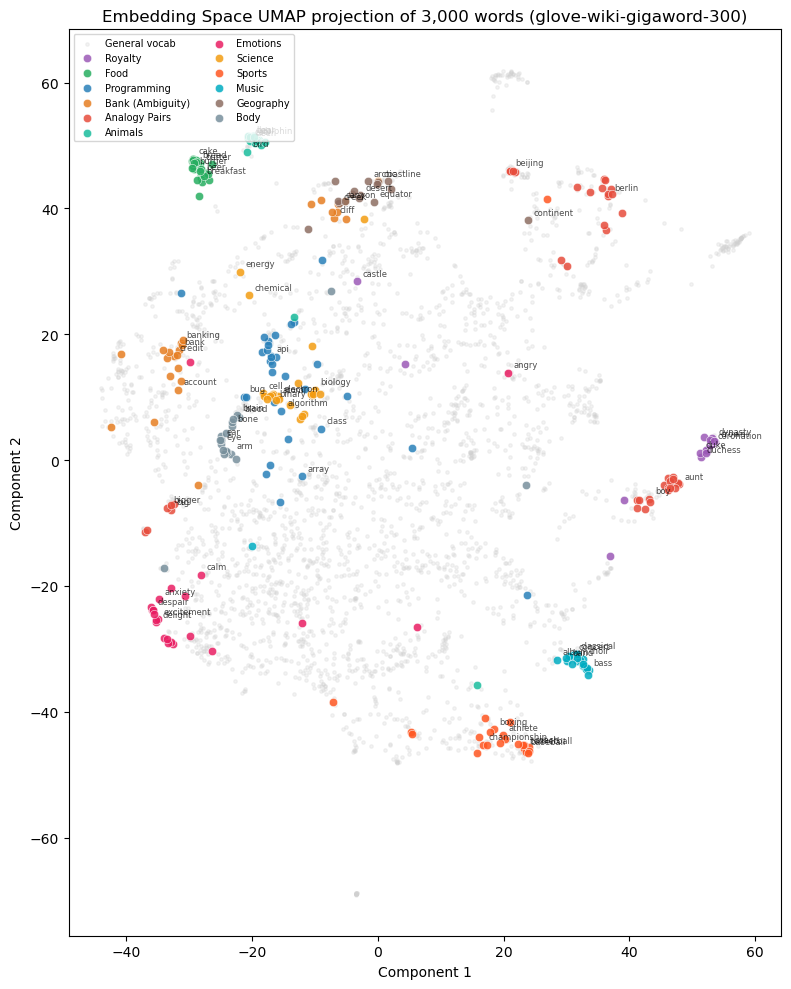

In [9]:
# ============================================================
# 9. PREVIEW PLOT  (use matplotlib for a QA quick visual check)
# ============================================================
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 10))

# Background: general vocabulary (gray, small, transparent)
gen_mask = np.array(
    [word_to_categories.get(w, []) == ["general"] for w in word_list]
)
ax.scatter(
    projected_2d[gen_mask, 0], projected_2d[gen_mask, 1],
    c="#D0D0D0", s=6, alpha=0.25, label="General vocab",
)

# Overlay each named category
for cat_name, cat_data in ALL_CATEGORIES.items():
    mask = np.array([cat_name in word_to_categories.get(w, []) for w in word_list])
    if not mask.any():
        continue
    pts = projected_2d[mask]
    ax.scatter(
        pts[:, 0], pts[:, 1],
        c=cat_data["color"], s=36, alpha=0.85,
        label=cat_data["label"], edgecolors="white", linewidths=0.4,
    )
    # Label a handful per cluster so you can eyeball correctness
    for idx in np.where(mask)[0][:6]:
        ax.annotate(
            word_list[idx],
            (projected_2d[idx, 0], projected_2d[idx, 1]),
            fontsize=6, alpha=0.7, xytext=(4, 4),
            textcoords="offset points",
        )

ax.legend(loc="upper left", fontsize=7, ncol=2)
ax.set_title(
    f"Embedding Space {projection_method.upper()} projection of "
    f"{len(word_list):,} words ({EMBEDDING_SOURCE})"
)
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

In [10]:
# ============================================================
# 10. EXPORT JSON FILES
# ============================================================

# ---------- File 1: embeddings_projected.json ----------
# Used by the scatter-plot visualization.
# Contains 2D and 3D coordinates, category tags, and category metadata.

categories_meta = {}
for cat_name, cat_data in ALL_CATEGORIES.items():
    categories_meta[cat_name] = {
        "color": cat_data["color"],
        "label": cat_data["label"],
        "isCaseFile": cat_name in DEMO_CATEGORIES,
    }

words_projected = []
for i, word in enumerate(word_list):
    words_projected.append({
        "word": word,
        "x": round(float(projected_2d[i, 0]), COORD_PRECISION),
        "y": round(float(projected_2d[i, 1]), COORD_PRECISION),
        "x3d": round(float(projected_3d[i, 0]), COORD_PRECISION),
        "y3d": round(float(projected_3d[i, 1]), COORD_PRECISION),
        "z3d": round(float(projected_3d[i, 2]), COORD_PRECISION),
        "categories": word_to_categories.get(word, ["general"]),
    })

projected_json = {
    "metadata": {
        "projection": projection_method,
        "nWords": len(word_list),
        "source": EMBEDDING_SOURCE,
        "coordRange": "roughly ±50",
        "has3d": True,
    },
    "categories": categories_meta,
    "words": words_projected,
}

proj_path = OUTPUT_DIR / "embeddings_projected.json"
with open(proj_path, "w") as f:
    json.dump(projected_json, f, separators=(",", ":"))   # compact
print(f"✓ {proj_path}  ({proj_path.stat().st_size / 1024:.0f} KB)")

# ---------- File 2: embeddings_full.json ----------
# Used by nearest-neighbor search and analogy computation in JS.
# Maps each word to its full-dimensional vector.

vectors_dict = {}
for i, word in enumerate(word_list):
    vectors_dict[word] = [round(float(v), VECTOR_PRECISION) for v in vectors[i]]

full_json = {
    "metadata": {
        "dimensions": int(vectors.shape[1]),
        "nWords": len(word_list),
        "source": EMBEDDING_SOURCE,
    },
    "vectors": vectors_dict,
}

full_path = OUTPUT_DIR / "embeddings_full.json"
with open(full_path, "w") as f:
    json.dump(full_json, f, separators=(",", ":"))
print(f"✓ {full_path}  ({full_path.stat().st_size / 1024 / 1024:.1f} MB)")

print(f"\n  Total export: {(proj_path.stat().st_size + full_path.stat().st_size) / 1024 / 1024:.1f} MB")


✓ /home/jovyan/work/data/embeddings_projected.json  (309 KB)
✓ /home/jovyan/work/data/embeddings_full.json  (6.4 MB)

  Total export: 6.7 MB


In [11]:
# ============================================================
# 11. QA: verify the JS demo will behave correctly
# ============================================================
#
# The JS demo computes nearest neighbors & analogies within our
# limited vocabulary (not the full 400K GloVe vocab). Let's
# simulate that here to make sure the results look right.

from numpy.linalg import norm

def cosine_sim(a, b):
    return np.dot(a, b) / (norm(a) * norm(b) + 1e-10)

def nearest_neighbors_in_vocab(query_vec, word_list, vectors, topn=10, exclude=None):
    """Nearest-neighbor search restricted to our exported vocabulary.
    This is what the JS demo will compute client-side."""
    exclude = set(exclude or [])
    sims = []
    for i, w in enumerate(word_list):
        if w in exclude:
            continue
        sims.append((w, cosine_sim(query_vec, vectors[i])))
    sims.sort(key=lambda x: -x[1])
    return sims[:topn]

def analogy_in_vocab(a, b, c, model, word_list, vectors, topn=5):
    """a is to b as c is to ??? — restricted to our vocabulary."""
    result_vec = model[a] - model[b] + model[c]
    return nearest_neighbors_in_vocab(
        result_vec, word_list, vectors, topn=topn,
        exclude={a, b, c},
    )

print("=" * 60)
print("VALIDATION (within exported vocabulary)")
print("=" * 60)

# --- Check 1: nearest neighbors for key words ---
for probe in ["king", "computer", "bank", "pizza", "happy"]:
    print(f'\n  Nearest neighbors for "{probe}":')
    nn = nearest_neighbors_in_vocab(
        model[probe], word_list, vectors, topn=8
    )
    for w, sim in nn:
        if w == probe:
            continue
        cats = word_to_categories.get(w, [])
        cat_str = ", ".join(cats) if cats != ["general"] else ""
        print(f"    {w:15s} {sim:.4f}  {cat_str}")

# --- Check 2: analogies within vocabulary ---
analogies = [
    ("king",  "man",    "woman",  "expect: queen"),
    ("paris", "france", "japan",  "expect: tokyo"),
    ("big",   "bigger", "small",  "expect: smaller"),
]
print("\n--- Analogies (within vocabulary) ---")
for a, b, c, note in analogies:
    results = analogy_in_vocab(a, b, c, model, word_list, vectors, topn=5)
    top = results[0][0]
    print(f"\n  {a} − {b} + {c} = ?  ({note})")
    for w, sim in results:
        marker = " ◀" if w == results[0][0] else ""
        print(f"    {w:15s} {sim:.4f}{marker}")

# --- Check 3: "bank" neighbors should mix finance + river terms ---
print('\n--- "bank" nearest neighbors (the ambiguity demo) ---')
nn = nearest_neighbors_in_vocab(model["bank"], word_list, vectors, topn=15)
finance_hits = []
river_hits = []
for w, sim in nn:
    if w == "bank":
        continue
    cats = word_to_categories.get(w, [])
    if "bank_ambiguity" in cats:
        # Rough classification based on which meaning
        if w in {"river", "water", "shore", "stream", "creek", "steep",
                 "erosion", "flood", "valley", "cliff", "riverbank"}:
            river_hits.append(w)
        elif w in {"deposit", "loan", "credit", "finance", "money",
                   "account", "interest", "investment", "savings",
                   "financial", "mortgage", "debt", "currency", "banking"}:
            finance_hits.append(w)
    print(f"    {w:15s} {sim:.4f}")

print(f"\n  Finance-related hits: {finance_hits}")
print(f"  River-related hits:   {river_hits}")
if finance_hits and river_hits:
    print("  ✓ Good! Both senses are represented — the ambiguity demo will work.")
elif not finance_hits or not river_hits:
    print("  ⚠ One sense dominates. Consider adding more words to bank_ambiguity category.")

# --- Check 4: cluster compactness ---
print("\n--- Cluster compactness (avg distance to centroid in 2D) ---")
for cat_name, cat_data in ALL_CATEGORIES.items():
    mask = np.array([cat_name in word_to_categories.get(w, []) for w in word_list])
    n = mask.sum()
    if n < 2:
        continue
    pts = projected_2d[mask]
    centroid = pts.mean(axis=0)
    avg_dist = np.mean(norm(pts - centroid, axis=1))
    print(f"  {cat_data['label']:20s}  avg_dist={avg_dist:5.2f}  (n={n})")

print("\n✓ Validation complete.")
print(f"\nOutput files ready in {OUTPUT_DIR.resolve()}/")
print(f"  • embeddings_projected.json  — scatter plot data")
print(f"  • embeddings_full.json       — vectors for NN search & analogies")

VALIDATION (within exported vocabulary)

  Nearest neighbors for "king":
    queen           0.6336  royalty
    prince          0.6197  royalty
    monarch         0.5900  royalty
    kingdom         0.5791  royalty
    throne          0.5606  royalty
    crown           0.5225  royalty
    reign           0.5217  royalty

  Nearest neighbors for "computer":
    computers       0.8248  
    software        0.7334  programming
    technology      0.6199  
    internet        0.5858  programming
    systems         0.5745  
    electronic      0.5527  
    microsoft       0.5375  

  Nearest neighbors for "bank":
    banks           0.7039  
    banking         0.6014  bank_ambiguity
    central         0.5376  
    credit          0.5314  bank_ambiguity
    financial       0.5000  bank_ambiguity
    investment      0.4982  bank_ambiguity
    monetary        0.4813  

  Nearest neighbors for "pizza":
    restaurant      0.5644  food
    sandwich        0.5562  food
    pasta           0

## What the JS demo will do with these files

**Scatter plot** (`embeddings_projected.json`):
- Plotly.js reads `words[]` and plots `(x, y)` for each word
- Gray dots for `"general"`, colored dots per category
- Case-file buttons filter/highlight by `categories.isCaseFile`
- Hover shows word label; click selects for nearest-neighbor panel

**Nearest-neighbor search** (`embeddings_full.json`):
- User types a word: look up its vector in `vectors[word]`
- Compute cosine similarity against all ~3,000 vectors
- Return top 10: trivially fast in JS for this vocabulary size

**Analogy playground** (`embeddings_full.json`):
- `result = vectors[A] - vectors[B] + vectors[C]`
- Nearest neighbor of `result` vector (excluding A, B, C)
- Animate the path on the scatter plot: A -> (−B) -> (+C) -> result